# Processing and Estimating Coordinated Daily Activity Patterns (CDAP) Model

This notebook processes the survey data and estimates the CDAP model. 

Last Updated: Nov 2024

Larch Version used: 5.7.2

# Load libraries

In [1]:
import pandas as pd
import numpy as np
import larch
import os
import matplotlib.pyplot as plt
from openpyxl import Workbook

pd.options.display.max_columns = 150

# 1. Pre-processing Coordinated Daily Activity Patterns (CDAP) Estimation Data Bundles (EDB) based on Household Travel Survey Data

The current generation process of the ActivitySim current estimation data bundle includes strict rules to meet requirements for all ActivitySim sub-models, resulting in dropped tour and trips when some attributes are missing or when a tour is incomplete. However, the dropped trips can result in an incorrect change to the person's daily activity pattern. For example, a person reporting a work tour that is dropped due to missing attributes that don't impact CDAP should have a mandatory day pattern, but the estimation data bundle updates it to a home pattern if the person has no valid trip records. 

The pre-procesing step reads in the cleaned household travel survey data, query the input survey trip data to find all person IDs with a work trip or non-mandatory trip, and update the estimation data bundle to the correct daily activity pattern as needed.

In [2]:
# model_iter variable used in naming estimation result spreadsheet
model_iter = 40
# update survey filepaths
survey_trips = pd.read_csv('./survey/survey_complete/survey_trips.csv')
asim_person_input = pd.read_csv('./survey/survey_asim_inputs/override_persons.csv')

C:\Users\teddy.lin\AppData\Local\Temp\2\ipykernel_17448\2474075849.py:4: DtypeWarning: Columns (61,127) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_trips = pd.read_csv('./survey/survey_complete/survey_trips.csv')


In [3]:
asim_person_input['cdap_activity_original'] = asim_person_input['cdap_activity']

purp_remove = ['Home', 'work', 'school']
#remove the purpose from the list
non_mand_purp_list = [x for x in survey_trips.purpose.value_counts().index.to_list() if x not in purp_remove]
mand_purp_list = ['work', 'school']

Do the check for mandatory trips

In [4]:
# Add mandatory indicator to survey trips to determine miscoded daily patterns H --> M
survey_trips['mand_indicator'] = np.where(survey_trips.purpose.isin(mand_purp_list), 1, 0)
agg_survey_trips = survey_trips.groupby('person_id').mand_indicator.sum().reset_index()
agg_survey_trips['mand_indicator'] = agg_survey_trips.mand_indicator.apply(lambda x: 1 if x > 0 else 0)

asim_person_input = pd.merge(asim_person_input, agg_survey_trips, on='person_id', how='left')

In [5]:
print('Original CDAP pattern from data bundle:')
asim_person_input.cdap_activity_original.value_counts()

Original CDAP pattern from data bundle:


H    2997
N    2015
M    1469
Name: cdap_activity_original, dtype: int64

In [6]:
pd.crosstab(asim_person_input.mand_indicator, asim_person_input.cdap_activity_original, margins=True)

cdap_activity_original,H,M,N,All
mand_indicator,,,,
0.0,751,0,1888,2639
1.0,838,1469,127,2434
All,1589,1469,2015,5073


Do the check for non-mandatory trips

In [7]:
# Add N indicator to survey trips to determine miscoded daily patterns H --> N
survey_trips['N_indicator'] = survey_trips.purpose.apply(lambda x: 1 if x in non_mand_purp_list else 0)
agg_survey_trips = survey_trips.groupby('person_id').N_indicator.sum().reset_index()
agg_survey_trips['N_indicator'] = agg_survey_trips.N_indicator.apply(lambda x: 1 if x > 0 else 0)

asim_person_input = pd.merge(asim_person_input, agg_survey_trips, on='person_id', how='left')


In [8]:
pd.crosstab(asim_person_input.N_indicator, asim_person_input.cdap_activity_original, margins=True)

cdap_activity_original,H,M,N,All
N_indicator,,,,
0.0,329,697,3,1029
1.0,1260,772,2012,4044
All,1589,1469,2015,5073


In [9]:
pd.crosstab(asim_person_input.N_indicator, asim_person_input.mand_indicator, margins=True)

mand_indicator,0.0,1.0,All
N_indicator,,,
0.0,7,1022,1029
1.0,2632,1412,4044
All,2639,2434,5073


In [10]:
#recode cdap indicator. M takes precendence over N, so if both are 1, it will be M
asim_person_input['cdap_activity'] = np.where(asim_person_input.mand_indicator==1, 'M', np.where(asim_person_input.N_indicator==1, 'N', 'H'))
asim_person_input.to_csv('./survey/survey_asim_inputs/override_persons_updated.csv', index=False)

In [11]:
display(pd.crosstab(asim_person_input.ptype, asim_person_input.cdap_activity_original, margins=True, normalize='index'))
display(pd.crosstab(asim_person_input.ptype, asim_person_input.cdap_activity, margins=True, normalize='index'))

cdap_activity_original,H,M,N
ptype,,,
1,0.420332,0.339582,0.240087
2,0.429429,0.244745,0.325826
3,0.455752,0.358407,0.185841
4,0.482100,0.000000,0.517900
5,0.465964,0.000000,0.534036
6,0.450000,0.450000,0.100000
7,0.588946,0.336788,0.074266
8,0.636364,0.189091,0.174545
All,0.462429,0.226663,0.310909


cdap_activity,H,M,N
ptype,,,
1,0.184571,0.535689,0.279740
2,0.159159,0.423423,0.417417
3,0.150442,0.557522,0.292035
4,0.294749,0.010740,0.694511
5,0.306807,0.000000,0.693193
6,0.250000,0.600000,0.150000
7,0.151986,0.696028,0.151986
8,0.320000,0.290909,0.389091
All,0.218331,0.375559,0.406110


In [12]:
pd.crosstab(asim_person_input.cdap_activity_original, asim_person_input.cdap_activity, margins=True)

cdap_activity,H,M,N,All
cdap_activity_original,,,,
H,1415,838,744,2997
M,0,1469,0,1469
N,0,127,1888,2015
All,1415,2434,2632,6481


# 2. Pre-processing CDAP EDB to Keep Only Valid Records
CDAP in the raw estimation data bundle out of ActivitySim is not representative of people's actual CDAP pattern. It includes households and people that may not have completed that particular survey day. For estimation, we only want households with a full survey day.

To do this, we overwrite the "override_choice" column in the estimation data bundle and take only persons who have a non-zero day weight (which is only true if the whole household survey day is complete)

In [13]:
# update estimation directory
estimation_path = r'C:/projects/psrc_estimation'
survey_asim_input_path = r'{dir}\survey\survey_asim_inputs'.format(dir=estimation_path)
cdap_dir = r'{dir}\output\estimation_data_bundle\cdap'.format(dir=estimation_path)

In [14]:
persons = pd.read_csv(r'{dir}\output\final_persons.csv'.format(dir=estimation_path))
households = pd.read_csv(r'{dir}\output\final_households.csv'.format(dir=estimation_path))
# tours = pd.read_csv(r'{dir}\output\final_tours.csv'.format(dir=estimation_path))
or_persons = pd.read_csv(survey_asim_input_path + "/override_persons_updated.csv")
or_households = pd.read_csv(survey_asim_input_path + "/override_households.csv")
or_tours = pd.read_csv(survey_asim_input_path + "/override_tours.csv")

In [15]:
if not os.path.exists(os.path.join(cdap_dir, 'cdap_values_combined_original.csv')):
    os.rename(os.path.join(cdap_dir, 'cdap_values_combined.csv'), os.path.join(cdap_dir, 'cdap_values_combined_original.csv'))
    full_edb = pd.read_csv(os.path.join(cdap_dir, 'cdap_values_combined_original.csv'))
    # can move all cdap_values_combined.csv changes here so they don't have to be re-run every time, but script will less organized
    full_edb.to_csv(os.path.join(cdap_dir, 'cdap_values_combined.csv'), index=False)
else:
    full_edb = pd.read_csv(os.path.join(cdap_dir, 'cdap_values_combined_original.csv'))


In [16]:
print("Original distributions:")
display(full_edb['override_choice'].value_counts(normalize=True))

Original distributions:


H    0.523083
N    0.295895
M    0.181022
Name: override_choice, dtype: float64

In [17]:
print("Number of total people in full EDB:", len(full_edb))

# taking only people who have a model_choice (can be na if hhsize != num people) and people who have a non-zero day weight
full_edb['person_weight'] = full_edb.person_id.map(or_persons.set_index('person_id').person_weight.to_dict())
df = full_edb[(~full_edb.model_choice.isna()) & (full_edb.person_weight > 0)].copy()

df['override_choice'] = df.person_id.map(or_persons.set_index('person_id').cdap_activity.to_dict())

print("Number after filtering:", len(df))

Number of total people in full EDB: 10159
Number after filtering: 6458


In [18]:
or_persons.cdap_activity.value_counts(normalize=True)

N    0.406110
M    0.375559
H    0.218331
Name: cdap_activity, dtype: float64

In [19]:
#find the weighted distribution of cdap_activity using person_weight
or_persons.groupby('cdap_activity').person_weight.sum()/or_persons.person_weight.sum()

cdap_activity
H    0.194470
M    0.467914
N    0.337616
Name: person_weight, dtype: float64

# 3. Pre-processing CDAP EDB to Recode Choice for Retirees and Non-Workers
ActivitySim does not allow retirees or non-workers to make work or school tours to a usual workplace or school location. In step 1, these persons can be incorrectly recoded to a mandatory day pattern. 

Recode retirees and non-workers who reported trips to a non-mandatory day pattern. 

In [20]:
# if person type is retired or non-worker, recode mandaotry pattern to non-mandatory
df['override_choice'] = np.where((df.ptype.isin([4,5]))&(df.override_choice=='M'), 'N', df.override_choice)

In [21]:
tmp = df[(df.person_weight > 0)]
tmp_ct = pd.crosstab(tmp.ptype, tmp.override_choice, margins=True)
display(tmp_ct.fillna(0).astype(int))
for col in tmp_ct.columns:
    tmp_ct[col] = tmp_ct[col] / tmp_ct.All
display((tmp_ct * 100).round(1))

override_choice,H,M,N,All
ptype,,,,
1,511,1478,775,2764
2,106,280,278,664
3,34,124,66,224
4,247,0,590,837
5,320,0,723,1043
6,20,48,12,80
7,88,402,86,576
8,84,80,106,270
All,1410,2412,2636,6458


override_choice,H,M,N,All
ptype,,,,
1,18.5,53.5,28.0,100.0
2,16.0,42.2,41.9,100.0
3,15.2,55.4,29.5,100.0
4,29.5,0.0,70.5,100.0
5,30.7,0.0,69.3,100.0
6,25.0,60.0,15.0,100.0
7,15.3,69.8,14.9,100.0
8,31.1,29.6,39.3,100.0
All,21.8,37.3,40.8,100.0


In [22]:
# add non-mandatory accessibility as a variable to test in estimation as an average of shopping and othdiscr accessibility
df['non_mand_accessibility'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2

# 4. Pre-processing CDAP EDB to Recode Choice based on Work-From-Home Status
ActivitySim does not generate a usual workplace location, work tours, and mandatory day patterns for workers who works from home 100% of the time.  

Recode work-from-home workers who reported trips to a non-mandatory day pattern.  

In [23]:
print("Checking for the need to recode any work from home M patterns to N to satisfy constraints in model:")
# this can happen becuase we calculate the raw CDAP before any filtering is done
display(df[(df.work_from_home) & (df.is_student == False) ].override_choice.value_counts())
df.loc[(df.work_from_home) & (df.is_student == False) & (df.override_choice == 'M'), 'override_choice'] = 'N'

Checking for the need to recode any work from home M patterns to N to satisfy constraints in model:


N    462
H    263
M     50
Name: override_choice, dtype: int64

In [24]:
for column in df.columns:
    # Check if the column is of numeric data type
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].fillna(0, inplace=True)
    # Check if the column is of object/string data type
    elif pd.api.types.is_object_dtype(df[column]):
        df[column].fillna('None', inplace=True)

In [25]:
df.to_csv(os.path.join(cdap_dir, 'cdap_values_combined.csv'), index=False)

# 5. Write out coefficients in the SPEC file

In [26]:
spec = pd.read_csv(os.path.join(cdap_dir, 'cdap_INDIV_AND_HHSIZE1_SPEC.csv'))
coeffs = spec[['M', 'N', 'H']].melt(value_name='coefficient_name')
coeffs = coeffs[~coeffs.coefficient_name.isna()].drop(columns='variable').drop_duplicates(subset='coefficient_name', keep='first')
coeffs['value'] = 0.0
coeffs['constrain'] = 'F'
coeffs.set_index('coefficient_name', inplace=True)
coeffs.loc['coef_UNAVAILABLE'] = (-999.0, 'T')
# constraint ASC's to zeros instead of removing them
coeffs.loc['coef_university_student_asc_N'] = (0.0, 'T')
coeffs.loc['coef_driving_age_child_who_is_in_school_asc_M'] = (0.0, 'T')
coeffs.loc['coef_pre_driving_age_child_who_is_too_young_for_school_asc_M'] = (0.0, 'T')
coeffs.to_csv(os.path.join(cdap_dir, 'coef_helper.csv'))

# 6. Load data and prep model for estimation

In [27]:
modelname = "cdap"

# import importlib
# importlib.reload(activitysim.estimation.larch)
from activitysim.estimation.larch import component_model
model, data = component_model(modelname, return_data=True)

Including joint tour utiltiy?: False


one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>


# 7. Review Inputs

## Settings

In [28]:
data.settings

┣          ADD_JOINT_TOUR_UTILITY: False
┣                    COEFFICIENTS: 'cdap_coefficients.csv'
┣                       CONSTANTS: ┣    DRIVING: 6
┃                                  ┣       FULL: 1
┃                                  ┣    NONWORK: 4
┃                                  ┣       PART: 2
┃                                  ┣  PRESCHOOL: 8
┃                                  ┣    RETIRED: 5
┃                                  ┣     SCHOOL: 7
┃                                  ┣ UNIVERSITY: 3
┣ FIXED_RELATIVE_PROPORTIONS_SPEC: 'cdap_fixed_relative_proportions.csv'
┣          INDIV_AND_HHSIZE1_SPEC: 'cdap_indiv_and_hhsize1.csv'
┣        INTERACTION_COEFFICIENTS: 'cdap_interaction_coefficients.csv'
┣         JOINT_TOUR_COEFFICIENTS: 'cdap_joint_tour_coefficients.csv'
┣       JOINT_TOUR_USEFUL_COLUMNS: None
┣                 PERSON_TYPE_MAP: ┣  CHILD: ---
┃                                  ┃         - 6
┃                                  ┃         - 7
┃                          

## Households

In [29]:
data.households

,home_zone_id,income,hhsize,HHT,auto_ownership,num_workers,hh_race_category,hh_weight,household_id_original,sample_rate,income_in_thousands,income_segment,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_6_to_12,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,workplace_location_accessibility,shopping_accessibility,othdiscr_accessibility,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,household_id
0,38962,175000,4,1,3,2,White Only,1200.335176,23000173,1,175.0,4,2,3,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,2.000000,1,1,1,0,0,1,False,0_tours,0,11
1,38962,175000,4,1,3,2,White Only,1200.335176,23000173,1,175.0,4,2,3,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,3.000000,0,1,0,0,1,1,False,0_tours,0,12
2,38962,175000,4,1,3,2,White Only,1200.335176,23000173,1,175.0,4,2,3,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,2.000000,1,0,0,0,0,0,False,0_tours,0,13
3,38962,175000,4,1,3,2,White Only,1200.335176,23000173,1,175.0,4,2,3,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,2.000000,1,2,2,0,0,2,True,1_Visit,1,14
4,52671,62500,1,1,1,1,Other,3427.635759,23000381,1,62.5,3,0,1,1,0,0,0,0,0,0,0,False,True,True,False,14.164272,13.156252,14.260718,1.000000,0,0,0,0,0,0,False,0_tours,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,23633,-1,2,1,2,0,White Only,89.743876,23421287,1,0.0,1,2,2,2,0,0,0,0,0,0,0,False,True,False,False,12.387463,11.610282,13.608382,0.000000,0,2,2,0,0,2,True,0_tours,0,36583
5774,23633,-1,2,1,2,0,White Only,89.743876,23421287,1,0.0,1,2,2,2,0,0,0,0,0,0,0,False,True,False,False,12.387463,11.610282,13.608382,0.000000,0,1,1,0,0,1,False,0_tours,0,36584
5775,51608,175000,2,1,2,0,Missing,133.311311,23422311,1,175.0,4,2,2,2,0,0,0,0,0,0,0,False,True,False,False,12.766229,10.543839,12.593760,1.000000,0,0,0,0,0,0,False,0_tours,0,36594
5776,33487,250000,4,1,3,2,Asian,4727.214865,23422853,1,250.0,4,2,2,2,2,0,2,0,0,0,0,False,True,False,False,13.875502,11.390380,13.291769,0.414987,1,2,1,0,1,2,True,0_tours,0,36601


## Person Data

In [30]:
data.person_data

,person_id,model_choice,override_choice,household_id,age,PNUM,sex,pemploy,pstudent,ptype,household_id_original,person_id_elmer_original,person_weight,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_preschool,is_gradeschool,is_highschool,is_university,school_segment,is_worker,is_out_of_home_worker,home_zone_id,time_factor_work,time_factor_nonwork,has_young_children,has_children_6_to_12,school_zone_id,school_location_logsum,school_modechoice_logsum,distance_to_school,roundtrip_auto_time_to_school,work_from_home,workplace_zone_id,workplace_location_logsum,workplace_modechoice_logsum,distance_to_work,workplace_in_cbd,work_zone_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,workplace_AGREMPN_share,workplace_FOOEMPN_share,workplace_FPSEMPN_share,workplace_HEREMPN_share,workplace_MWTEMPN_share,workplace_OTHEMPN_share,workplace_RETEMPN_share,pay_to_park_at_work,log_employment_density_at_work,free_parking_at_work,telecommute_frequency,income,hhsize,HHT,auto_ownership,num_workers,hh_race_category,hh_weight,sample_rate,...,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_6_to_12,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,workplace_location_accessibility,shopping_accessibility,othdiscr_accessibility,hh_work_auto_savings_ratio,TAZ,DISTRICT,SD,county_id,TOTHH,TOTPOP,TOTACRE,RESACRE,CIACRE,TOTEMP,AGE0519,RETEMPN,FPSEMPN,HEREMPN,OTHEMPN,AGREMPN,MWTEMPN,FOOEMPN,PRKCST,OPRKCST,area_type,HSENROLL,COLLFTE,COLLPTE,TOPOLOGY,TERMINAL,transit_score_scaled,buff_density_index,GSENROLL,access_dist_transit,hh_1,emptot_1,density_index,log_emptot_1,log_hh_1,preschool_target,auPkRetail,auPkTotal,auOpRetail,auOpTotal,trPkRetail,trPkTotal,trOpRetail,trOpTotal,nmRetail,nmTotal,TotalAcc,workplace_location_accessibility_0,workplace_location_accessibility_1,workplace_location_accessibility_2,othdiscr_accessibility_0,othdiscr_accessibility_1,othdiscr_accessibility_2,shopping_accessibility_0,shopping_accessibility_1,shopping_accessibility_2,chunk_id,non_mand_accessibility,cdap_rank
0,131,M,H,13,50,1,1,1,3,1,23000173,2300017301,4801.340704,False,True,True,True,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,0,True,True,38962,0.752707,0.869693,False,False,-1,0.000000,0.000000,0.000000,0.000000,False,39319,-0.392944,-0.392944,9.970769,False,5.0,38.051712,190.005140,1.000000,0.000000,0.392523,0.149533,0.102804,0.018692,0.242991,0.093458,0,8.567205,False,2_3_days_week,175000,4,1,3,2,White Only,1200.335176,1,...,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,2.000000,3651,-1,-1,2,22,55,3.151372,3.151372,0.000000,0,9,0,0,0,0,0,0,0.0,0.0,-1.0,4,0.0,0.0,0.0,1,1.0,0.000000,12.811736,0.0,1.474770,275.150930,13.437416,5.668460,2.669823,5.620948,55,7.317544,9.277708,7.713656,9.804980,0.000088,0.000487,8.720000e-05,4.769250e-04,1.420041,3.043267,9.079619,13.220136,12.942168,12.870163,13.553408,12.890630,12.970139,12.870948,11.371093,11.542802,5775,12.256470,2
1,132,N,H,13,17,2,1,3,1,6,23000173,2300017302,4801.340704,True,True,False,True,False,False,False,False,False,True,True,True,False,False,False,True,False,False,True,False,3,False,False,38962,0.224873,0.877038,False,False,37923,1.495810,1.495810,5.677939,27.886604,False,-1,0.000000,0.000000,0.000000,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,False,None,175000,4,1,3,2,White Only,1200.335176,1,...,2,2,0,1,0,1,0,0,False,True,False,False,12.870163,11.542802,12.970139,2.000000,3651,-1,-1,2,22,55,3.151372,3.151372,0.000000,0,9,0,0,0,0,0,0,0.0,0.0,-1.0,4,0.0,0.0,0.0,1,1.0,0.000000,12.811736,0.0,1.474770,275.150930,13.437416,5.668460,2.669823,5.620948,55,7.317544,9.277708,7.713656,9.804980,0.000088,0.000487,8.720000e-05,4

In [31]:
data.person_data.override_choice.value_counts(normalize=True)

N    0.415918
M    0.365748
H    0.218334
Name: override_choice, dtype: float64

In [32]:
df = data.person_data.copy()
df['mand_status'] = np.select(condlist=[df.is_worker, df.is_student, (df.is_worker & df.is_student), ~(df.is_worker | df.is_student)], choicelist=['worker', 'student', 'both', 'neither'])
pd.crosstab(df.mand_status, df.override_choice, margins=True)

override_choice,H,M,N,All
mand_status,,,,
neither,567,0,1311,1878
student,212,561,247,1020
worker,631,1801,1128,3560
All,1410,2362,2686,6458


In [33]:
pd.crosstab(df.ptype, df.override_choice, margins=True, normalize='index')

override_choice,H,M,N
ptype,,,
1,0.184877,0.521708,0.293415
2,0.159639,0.400602,0.439759
3,0.151786,0.553571,0.294643
4,0.295102,0.000000,0.704898
5,0.306807,0.000000,0.693193
6,0.250000,0.600000,0.150000
7,0.152778,0.697917,0.149306
8,0.311111,0.296296,0.392593
All,0.218334,0.365748,0.415918


In [34]:
pd.crosstab(df.telecommute_frequency, df.override_choice, margins=True, normalize='columns')

override_choice,H,M,N,All
telecommute_frequency,,,,
1_day_week,0.013475,0.059272,0.013775,0.030350
2_3_days_week,0.073050,0.157494,0.066270,0.101115
4_days_week,0.086525,0.051651,0.075949,0.069371
No_Telecommute,0.087234,0.492379,0.072599,0.229328
None,0.739716,0.239204,0.771407,0.569836


In [35]:
df.auPkTotal.describe()

count    6458.000000
mean       11.006209
std         0.984260
min         4.625016
25%        10.646936
50%        11.221930
75%        11.746103
max        12.257896
Name: auPkTotal, dtype: float64

In [36]:
df.auOpRetail.describe()

count    6458.000000
mean        9.211248
std         0.879346
min         3.102218
25%         8.902556
50%         9.493229
75%         9.821049
max        10.179421
Name: auOpRetail, dtype: float64

<Axes: >

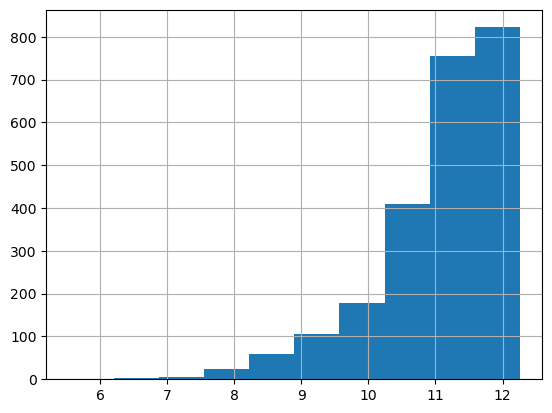

In [37]:
df[df.override_choice=='M'].auPkTotal.hist()

In [38]:
def create_N_by_access(df, bins=10):
    df['non_mand_access'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2
    df['non_mand_access_binned'], bins = pd.cut(df.non_mand_access, bins=10, retbins=True)
    df['N_cdap'] = np.where(df.override_choice == 'N', 1, 0)
    N_by_access = df.groupby('non_mand_access_binned').agg({'person_id': 'count', 'N_cdap': 'sum'}).rename(columns={'person_id': 'num_persons'})
    N_by_access['percent_N'] = (N_by_access.N_cdap / N_by_access.num_persons).round(3) * 100
    return N_by_access

def create_M_by_access(df, bins=10):
    df['non_mand_access'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2
    df['non_mand_access_binned'], bins = pd.cut(df.non_mand_access, bins=10, retbins=True)
    df['M_cdap'] = np.where(df.override_choice == 'M', 1, 0)
    M_by_access = df.groupby('non_mand_access_binned').agg({'person_id': 'count', 'M_cdap': 'sum'}).rename(columns={'person_id': 'num_persons'})
    M_by_access['percent_M'] = (M_by_access.M_cdap / M_by_access.num_persons).round(3) * 100
    return M_by_access

,num_persons,M_cdap,percent_M
non_mand_access_binned,,,
"(6.649, 7.866]",4,1,25.0
"(7.866, 9.071]",4,4,100.0
"(9.071, 10.276]",27,12,44.4
"(10.276, 11.481]",205,55,26.8
"(11.481, 12.687]",587,171,29.1
"(12.687, 13.892]",1607,587,36.5
"(13.892, 15.097]",2814,1082,38.5
"(15.097, 16.302]",706,275,39.0
"(16.302, 17.507]",193,69,35.8


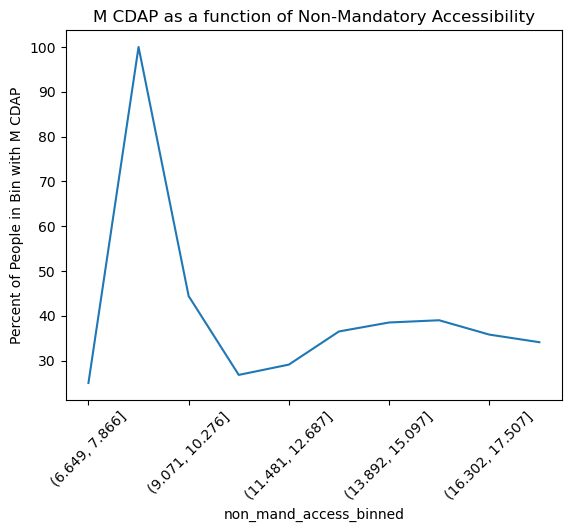

In [39]:
M_by_access_total = create_M_by_access(df, bins=10)
display(M_by_access_total)
M_by_access_total.percent_M.plot()
plt.xticks(rotation=45)
plt.ylabel('Percent of People in Bin with M CDAP')
plt.title('M CDAP as a function of Non-Mandatory Accessibility')
plt.show()

In [40]:
data.person_data.non_mand_accessibility.value_counts(dropna=False)

13.459619    16
14.585741    15
13.968740    14
13.731855    13
13.902426    11
             ..
13.685763     1
11.835400     1
13.687899     1
11.524060     1
13.895924     1
Name: non_mand_accessibility, Length: 2972, dtype: int64

In [41]:
data.person_data.age.value_counts(dropna=False)

30    1262
40    1113
70     846
60     835
50     766
8      394
80     386
21     274
2      270
14     182
17      80
85      50
Name: age, dtype: int64

In [42]:
data.person_data.income_in_thousands.value_counts()

125.0    1219
0.0       845
250.0     782
175.0     749
62.5      738
87.5      637
225.0     508
42.5      367
17.5      262
30.0      196
5.0       155
Name: income_in_thousands, dtype: int64

In [43]:
data.person_data.override_choice.value_counts(normalize=True)

N    0.415918
M    0.365748
H    0.218334
Name: override_choice, dtype: float64

## interaction_coef

In [44]:
data.interaction_coef

,activity,interaction_ptypes,coefficient,cardinality,slug
0,H,11,1.6260,2,HH11
1,H,13,1.1830,2,HH13
2,H,14,0.9436,2,HH14
3,H,15,1.2980,2,HH15
4,H,16,2.0640,2,HH16
5,H,18,0.9912,2,HH18
6,H,23,1.6420,2,HH23
7,H,24,0.7057,2,HH24
8,H,25,0.4630,2,HH25
9,H,27,0.7685,2,HH27


## Spec 1

In [45]:
data.spec1

,Description,Expression,M,N,H
0,Full-time worker alternative-specific constants,ptype == 1,coef_full_time_worker_asc_M,coef_full_time_worker_asc_N,NaN
1,Part-time worker alternative-specific constants,ptype == 2,coef_part_time_worker_asc_M,coef_part_time_worker_asc_N,NaN
2,University student alternative-specific constants,ptype == 3,coef_university_student_asc_M,coef_university_student_asc_N,NaN
3,Non-working adult alternative-specific constants,ptype == 4,coef_UNAVAILABLE,coef_non_working_adult_asc_N,NaN
4,Retired alternative-specific constants,ptype == 5,coef_UNAVAILABLE,coef_retired_asc_N,NaN
5,Driving-age child who is in school alternative...,ptype == 6,coef_driving_age_child_who_is_in_school_asc_M,coef_driving_age_child_who_is_in_school_asc_N,NaN
6,Pre-driving-age child who is in school alterna...,ptype == 7,coef_pre_driving_age_child_who_is_in_school_asc_M,coef_pre_driving_age_child_who_is_in_school_asc_N,NaN
7,Pre-driving-age child who is too young for sch...,ptype == 8,coef_pre_driving_age_child_who_is_too_young_fo...,coef_pre_driving_age_child_who_is_too_young_fo...,NaN
8,Part-time worker interaction with age less tha...,(ptype == 2) & (age < 35),coef_part_time_worker_interaction_with_age_les...,coef_part_time_worker_interaction_with_age_les...,NaN
9,University student interaction with age less t...,(ptype == 3) & (age < 25),coef_university_student_interaction_with_age_l...,NaN,NaN


# 8. Review Model

## Utility Functions for HHSize 1

In [46]:
model[0].utility_functions() ## HH Size = 1 

<xmle.Elem 'div' with 1 children>

## Utility Functions for HHSize 2

In [47]:
model[1].utility_functions() ## HH Size = 2

<xmle.Elem 'div' with 1 children>

# 9. Estimate Model

With the model setup for estimation, the next step is to estimate the model coefficients. Make sure to use a sufficiently large enough sample and set of zones to avoid an over-specified model, which does not have a numerically stable likelihood maximizing solution. Larch has two built-in estimation methods: BHHH and SLSQP. BHHH is the default and typically runs faster, but does not follow constraints on parameters.  SLSQP is safer, but slower, and may need additional iterations.

In [48]:
modelname = "cdap"

# import importlib
# importlib.reload(activitysim.estimation.larch)
from activitysim.estimation.larch import component_model
model, data = component_model(modelname, return_data=True)

data.spec1

Including joint tour utiltiy?: False


one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>


,Description,Expression,M,N,H
0,Full-time worker alternative-specific constants,ptype == 1,coef_full_time_worker_asc_M,coef_full_time_worker_asc_N,NaN
1,Part-time worker alternative-specific constants,ptype == 2,coef_part_time_worker_asc_M,coef_part_time_worker_asc_N,NaN
2,University student alternative-specific constants,ptype == 3,coef_university_student_asc_M,coef_university_student_asc_N,NaN
3,Non-working adult alternative-specific constants,ptype == 4,coef_UNAVAILABLE,coef_non_working_adult_asc_N,NaN
4,Retired alternative-specific constants,ptype == 5,coef_UNAVAILABLE,coef_retired_asc_N,NaN
5,Driving-age child who is in school alternative...,ptype == 6,coef_driving_age_child_who_is_in_school_asc_M,coef_driving_age_child_who_is_in_school_asc_N,NaN
6,Pre-driving-age child who is in school alterna...,ptype == 7,coef_pre_driving_age_child_who_is_in_school_asc_M,coef_pre_driving_age_child_who_is_in_school_asc_N,NaN
7,Pre-driving-age child who is too young for sch...,ptype == 8,coef_pre_driving_age_child_who_is_too_young_fo...,coef_pre_driving_age_child_who_is_too_young_fo...,NaN
8,Part-time worker interaction with age less tha...,(ptype == 2) & (age < 35),coef_part_time_worker_interaction_with_age_les...,coef_part_time_worker_interaction_with_age_les...,NaN
9,University student interaction with age less t...,(ptype == 3) & (age < 25),coef_university_student_interaction_with_age_l...,NaN,NaN


In [49]:
model.estimate(method='BHHH', options={'maxiter':100})
# model.estimate(method='SLSQP', options={'maxiter':1500})

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
coef_UNAVAILABLE,-999.000000,-999.0,0.0,-999.0,-999.0,1,,-999.000000
coef_driving_age_child_who_is_in_school_asc_M,0.000000,0.0,0.0,0.0,0.0,1,,0.000000
coef_driving_age_child_who_is_in_school_asc_N,-0.351879,0.0,0.0,NaN,NaN,0,,-0.351879
coef_driving_age_child_who_is_in_school_interaction_with_cars_greater_than_or_equal_adults_M,1.044131,0.0,0.0,NaN,NaN,0,,1.044131
coef_full_time_worker_asc_M,2.631608,0.0,0.0,NaN,NaN,0,,2.631608
...,...,...,...,...,...,...,...,...
coef_H_xxxx,0.924107,0.0,0.0,NaN,NaN,0,,0.924107
coef_M_xxxx,0.465317,0.0,0.0,NaN,NaN,0,,0.465317
coef_N_124_122_144,-2.066423,0.0,0.0,NaN,NaN,0,,-2.066423
coef_N_222_224_444,-1.075825,0.0,0.0,NaN,NaN,0,,-1.075825


c:\Users\teddy.lin\.conda\envs\asim\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


┣                x: coef_UNAVAILABLE                                                                               -999.000000
┃                   coef_driving_age_child_who_is_in_school_asc_M                                                     0.000000
┃                   coef_driving_age_child_who_is_in_school_asc_N                                                    -0.351879
┃                   coef_driving_age_child_who_is_in_school_interaction_with_cars_greater_than_or_equal_adults_M      1.044131
┃                   coef_full_time_worker_asc_M                                                                       2.631608
┃                                                                                                                      ...    
┃                   coef_H_xxxx                                                                                       0.924107
┃                   coef_M_xxxx                                                                                       0.465317
┃                   coef_N_124_122_144                                                                               -2.066423
┃                   coef_N_222_224_444                                                                               -1.075825
┃                   coef_N_xxxx                                                                                       0.803625
┃                   Length: 99, dtype: float64
┣          loglike: -4493.993127970379
┣        d_loglike: coef_UNAVAILABLE                                                                                0.000000
┃                   coef_driving_age_child_who_is_in_school_asc_M                                                   0.256563
┃                   coef_driving_age_child_who_is_in_school_asc_N                                                   0.000081
┃                   coef_driving_age_child_who_is_in_school_interaction_with_cars_greater_than_or_equal_adults_M   -0.000534
┃                   coef_full_time_worker_asc_M                                                                     0.000890
┃                                                                                                                     ...   
┃                   coef_H_xxxx                                                                                     0.000206
┃                   coef_M_xxxx                                                                                     0.000243
┃                   coef_N_124_122_144                                                                              0.000042
┃                   coef_N_222_224_444                                                                             -0.000437
┃                   coef_N_xxxx                                                                                     0.000007
┃                   Length: 99, dtype: float64
┣              nit: 63
┣             nfev: 160
┣             njev: 63
┣           status: 0
┣          message: 'Optimization terminated successfully'
┣          success: True
┣     elapsed_time: datetime.timedelta(seconds=59, microseconds=857668)
┣           method: 'slsqp'
┣          n_cases: 3453
┣ iteration_number: 63
┣          logloss: 1.3014749863800692

In [50]:
model_estimation_results = model.parameter_summary()
model_estimation_results = model_estimation_results.data
model_estimation_results.loc['log_likelihood', 'Value'] = model.loglike()
model_estimation_results

,Value,Std Err,t Stat,Signif,Null Value
coef_UNAVAILABLE,-999.,0.00,NA,,0.0
coef_driving_age_child_who_is_in_school_asc_M,0.00,0.00,NA,,0.0
coef_driving_age_child_who_is_in_school_asc_N,-0.352,0.373,-0.94,,0.0
coef_driving_age_child_who_is_in_school_interaction_with_cars_greater_than_or_equal_adults_M,1.04,0.376,2.78,**,0.0
coef_full_time_worker_asc_M,2.63,0.124,21.16,***,0.0
...,...,...,...,...,...
coef_M_xxxx,0.465,0.179,2.60,**,0.0
coef_N_124_122_144,-2.07,1.05,-1.97,*,0.0
coef_N_222_224_444,-1.08,0.690,-1.56,,0.0
coef_N_xxxx,0.804,0.188,4.27,***,0.0


# 10. Output Estimation Results

In [51]:
#from larch.util.activitysim import update_coefficients
#coefficients = update_coefficients(model, data)

result_dir = data.edb_directory/'estimated'

os.makedirs(result_dir, exist_ok=True)

#coefficients.reset_index().to_csv(
#    result_dir/"cdap_coefficients_revised.csv", 
#    index=False,
#)

In [53]:
import numpy as np
#get the list of rows whose "t Stat" column is less than 1.76 in absolute value
# Replace '\xa0NA' with NaN
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].replace('\xa0NA', np.nan)
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].replace('\xa0BIG', 9999)
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].replace('-BIG', -9999)

# Fill NA/NaN values with 0
model_estimation_results['t Stat'].fillna(0, inplace=True)

# Convert "t Stat" from str to float
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].astype(float)

# Get the list of rows whose "t Stat" column is less than 1.65 in absolute value (p value of 0.1)
insig_coefs = model_estimation_results[np.abs(model_estimation_results['t Stat']) < 1.65]
# insig_coefs = insig_coefs[insig_coefs.index.str.startswith(('coef_H_', 'coef_N_', 'coef_M_'))]
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].replace(9999, '\xa0BIG')
model_estimation_results['t Stat'] = model_estimation_results['t Stat'].replace(-9999, '-BIG')
display(insig_coefs)

# this section automates the removal of insignificant coefficients for the next estimation run by commenting out insignificant coefficients,
# but note that it overwrites the cdap_coefficients.csv and cdap_interaction_coefficients.csv files of the latest run in cdap_dir
# cdap_coefs = pd.read_csv(os.path.join(cdap_dir, 'cdap_coefficients.csv'))
# 
# cdap_coefs['coefficient_name'] = np.where(cdap_coefs.coefficient_name.isin(insig_coefs.index), '#' + cdap_coefs.coefficient_name , cdap_coefs.coefficient_name)
# cdap_coefs.to_csv(os.path.join(cdap_dir, 'cdap_coefficients.csv'), index=False)
# 
# cdap_inter_coefs = pd.read_csv(os.path.join(cdap_dir, 'cdap_interaction_coefficients.csv'))
# cdap_inter_coefs['interaction_ptypes'].fillna(0, inplace=True)
# cdap_inter_coefs['interaction_ptypes'] = cdap_inter_coefs['interaction_ptypes'].astype('Int64')
# cdap_inter_coefs['_tempcol'] = cdap_inter_coefs.apply(lambda row: 'coef_' + row['activity'] + '_' + str(row['interaction_ptypes']), axis=1)
# cdap_inter_coefs['activity'] = np.where(cdap_inter_coefs._tempcol.isin(insig_coefs.index), '#' + cdap_inter_coefs.activity , cdap_inter_coefs.activity)
# cdap_inter_coefs.drop(columns='_tempcol', inplace=True)
# cdap_inter_coefs.replace({'interaction_ptypes': {0: np.nan}}, inplace=True)
# cdap_inter_coefs.to_csv(os.path.join(cdap_dir, 'cdap_interaction_coefficients.csv'), index=False)



,Value,Std Err,t Stat,Signif,Null Value
coef_UNAVAILABLE,-999.,0.00,0.00,,0.0
coef_driving_age_child_who_is_in_school_asc_M,0.00,0.00,0.00,,0.0
coef_driving_age_child_who_is_in_school_asc_N,-0.352,0.373,-0.94,,0.0
coef_full_time_worker_asc_N,0.247,0.165,1.49,,0.0
coef_full_time_worker_interaction_with_medium_high_non_mand_accessibility_N,0.153,0.125,1.23,,0.0
coef_full_time_worker_interaction_with_telecommute_1_day_week_H,0.228,0.298,0.76,,0.0
coef_full_time_worker_interaction_with_zero_cars_M,-0.260,0.188,-1.38,,0.0
coef_part_time_worker_interaction_with_telecommute_1_day_week_H,0.807,0.671,1.20,,0.0
coef_pre_driving_age_child_who_is_in_school_asc_N,-0.257,0.215,-1.20,,0.0
coef_pre_driving_age_child_who_is_too_young_for_school_asc_M,0.00,0.00,0.00,,0.0


### Write the re-estimated coefficients file

In [54]:
writer_mode = 'a'
if not os.path.exists(os.path.join(result_dir, 'cdap_estimation_results.xlsx')):
    writer_mode = 'w'
with pd.ExcelWriter(os.path.join(result_dir, 'cdap_estimation_results.xlsx'), engine='openpyxl', mode=writer_mode) as writer:
    # Write each DataFrame to a different worksheet
    model_estimation_results.to_excel(writer, sheet_name=f'estimation_{model_iter}')

In [109]:
coef_revised = model_estimation_results.reset_index().rename(columns={'index': 'coefficient_name', 'Value': 'value'})[['coefficient_name', 'value']]
coef_revised = coef_revised[(coef_revised['coefficient_name'] != 'log_likelihood') & (coef_revised['coefficient_name'] != '-999.0')]
coef_constrain = coeffs.reset_index().rename(columns={'index': 'coefficient_name'})[['coefficient_name', 'constrain']]
coef_revised = pd.merge(coef_revised, 
                             coef_constrain, 
                             on='coefficient_name', 
                             how='left')
coef_revised['value'] = coef_revised['value'].astype(float)
coef_revised['constrain'].fillna('F', inplace = True)
coef_revised

,coefficient_name,value,constrain
0,coef_UNAVAILABLE,-999.000,T
1,coef_driving_age_child_who_is_in_school_asc_M,0.000,T
2,coef_driving_age_child_who_is_in_school_asc_N,-0.352,F
3,coef_driving_age_child_who_is_in_school_intera...,1.040,F
4,coef_full_time_worker_asc_M,2.630,F
...,...,...,...
93,coef_H_xxxx,0.924,F
94,coef_M_xxxx,0.465,F
95,coef_N_124_122_144,-2.070,F
96,coef_N_222_224_444,-1.080,F


In [130]:
original_coef = pd.read_csv(os.path.join(cdap_dir, 'cdap_coefficients.csv'))
constrained_interaction_coef = original_coef[(original_coef['coefficient_name'].str.contains('#coef_M_')) | 
                                             (original_coef['coefficient_name'].str.contains('#coef_N_')) | 
                                             (original_coef['coefficient_name'].str.contains('#coef_H_'))]
constrained_interaction_coef['coefficient_name'] = constrained_interaction_coef['coefficient_name'].str.replace('#', '')
constrained_interaction_coef['constrain'] = 'T'
constrained_interaction_coef

,coefficient_name,value,constrain
143,coef_H_12,0,T
148,coef_H_17,0,T
150,coef_H_22,0,T
154,coef_H_26,0,T
157,coef_H_33,0,T
...,...,...,...
241,coef_N_166,0,T
243,coef_N_246_226_446,0,T
250,coef_M_xxxxx,0,T
251,coef_N_xxxxx,0,T


In [138]:
coef_revised = pd.concat([coef_revised, constrained_interaction_coef])
coef_revised

,coefficient_name,value,constrain
0,coef_UNAVAILABLE,-999.000,T
1,coef_driving_age_child_who_is_in_school_asc_M,0.000,T
2,coef_driving_age_child_who_is_in_school_asc_N,-0.352,F
3,coef_driving_age_child_who_is_in_school_intera...,1.040,F
4,coef_full_time_worker_asc_M,2.630,F
...,...,...,...
241,coef_N_166,0.000,T
243,coef_N_246_226_446,0.000,T
250,coef_M_xxxxx,0.000,T
251,coef_N_xxxxx,0.000,T


In [140]:
coef_revised.to_csv(
    result_dir/"cdap_coefficients_revised.csv", 
    index=False,
)

In [55]:
#pf_coef_merge = pd.merge(model.pf, coefficients, left_index=True, right_index=True, how='outer', indicator=True)
#pf_coef_merge['_merge'].value_counts()

right_only    114
both           56
left_only      43
Name: _merge, dtype: int64

In [56]:
#pf_coef_merge[pf_coef_merge['_merge'] == 'left_only']

,value_x,initvalue,nullvalue,minimum,maximum,holdfast,note,best,std_err,t_stat,robust_std_err,robust_t_stat,value_y,constrain,_merge
-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0,1.0,,-999.000000,0.000000,NaN,0.0,NaN,NaN,NaN,left_only
coef_full_time_worker_interaction_with_high_non_mand_accessibility_N,0.389446,0.0,0.0,-inf,inf,0.0,,0.389446,0.115192,3.380852,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_medium_high_non_mand_accessibility_N,0.153184,0.0,0.0,-inf,inf,0.0,,0.153184,0.124599,1.229411,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_1_day_week_H,0.227786,0.0,0.0,-inf,inf,0.0,,0.227786,0.298168,0.763952,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_1_day_week_N,0.425434,0.0,0.0,-inf,inf,0.0,,0.425434,0.247897,1.716173,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_2_3_days_week_H,1.035738,0.0,0.0,-inf,inf,0.0,,1.035738,0.163606,6.330699,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_2_3_days_week_N,1.260171,0.0,0.0,-inf,inf,0.0,,1.260171,0.144979,8.692093,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_4_days_week_H,2.463926,0.0,0.0,-inf,inf,0.0,,2.463926,0.180313,13.664711,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_telecommute_4_days_week_N,2.672748,0.0,0.0,-inf,inf,0.0,,2.672748,0.165260,16.172967,0.0,inf,NaN,NaN,left_only
coef_full_time_worker_interaction_with_work_from_home_N,0.407652,0.0,0.0,-inf,inf,0.0,,0.407652,0.171497,2.377023,0.0,inf,NaN,NaN,left_only


### Write the model estimation report, including coefficient t-statistic and log likelihood

In [57]:
for hh_size, submodel in enumerate(model, 1):
    if hh_size > 3: 
        break 
        # the largest HH sizes have massive model reports that 
        # Excel doesn't handle well; review them in Jupyter 
        # instead if you are interested
    submodel.to_xlsx(
        result_dir/f"cdap_model_estimation_hhsize{hh_size}.xlsx", 
        data_statistics=True,
    )

c:\Users\teddy.lin\.conda\envs\asim\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)
c:\Users\teddy.lin\.conda\envs\asim\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)
c:\Users\teddy.lin\.conda\envs\asim\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)


# 11. Next Steps

The final step is to either manually or automatically copy the `cdap_coefficients.csv_revised.csv` file to the configs folder, rename it to `cdap_coefficients.csv`, and run ActivitySim in simulation mode.

In [58]:
pd.read_csv(result_dir/"cdap_coefficients_revised.csv")

,coefficient_name,value,constrain
0,coef_UNAVAILABLE,-999.000000,T
1,coef_full_time_worker_asc_M,2.631608,F
2,coef_full_time_worker_asc_N,0.246739,F
3,coef_part_time_worker_asc_M,2.460176,F
4,coef_part_time_worker_asc_N,0.908382,F
...,...,...,...
165,coef_N_xxx,0.000000,F
166,coef_H_xxx,0.000000,F
167,coef_M_xxxx,0.465317,F
168,coef_N_xxxx,0.803625,F
